In [1]:
import numpy as np

from scipy.special import j1, struve

from AcousticProperties import *
from GmshBoundaries import *
from RayleighSolver import *
from SamplingPatterns import *

from Plots import *
%matplotlib inline

import gmsh
from joblib import Parallel, delayed


def magnitude(k, boundaryCondition, aSamples):
    solution = solver.solveBoundary(k, boundaryCondition)
    phi = solver.solveSamples(solution, aSamples)
    return SoundMagnitude(soundPressure(k, phi))

def theoreticalPressure(R, V, k, r, theta, rho = 1.205, c = 344.0):
    "From Morse & Ingard: Theoretical Acoustics"
    sin_theta = k * R * np.sin(theta)
    f_omega = 2.0 * V * np.pi * R**2 * (2.0 * j1(sin_theta) / sin_theta)
    return -1j * k * rho * c * np.exp(1j * k * r) / (4 * np.pi * r) * f_omega

def theoreticalMagnitude(R, V, k, r, theta, rho = 1.205, c = 344.0):
    return SoundMagnitude(theoreticalPressure(R, V, k, r, theta, rho, c))

def analyticalZm(r, aK, rho, c):
    "From Pierce: Acoustics"
    R1 = 1.0 - 2 * j1(2.0 * aK * r) / (2.0 * aK * r)
    X1 = 2 * struve(1, 2.0 * aK * r) / (2.0 * aK * r)
    Zm = density * c * np.pi * r**2 * (R1 - 1j * X1)
    return Zm

def numericalZm(k, boundaryCondition):
    solution = solver.solveBoundary(k, boundaryCondition)
    return solution.mechanicalImpedance()


V = 1.0 # piston velocity
c = 344.0
density = 1.205
r = 0.19
nMaxEdge = 0.0475

aVertex, aTriangle = disk(r, 0.0, "Woofer15", nMaxEdge) # 15 inch woofer
aSamples, _, aAngle = semiCircle(5, 180, "yz")

aFrequency = np.array([100, 500, 1000, 5000], dtype=np.float32)

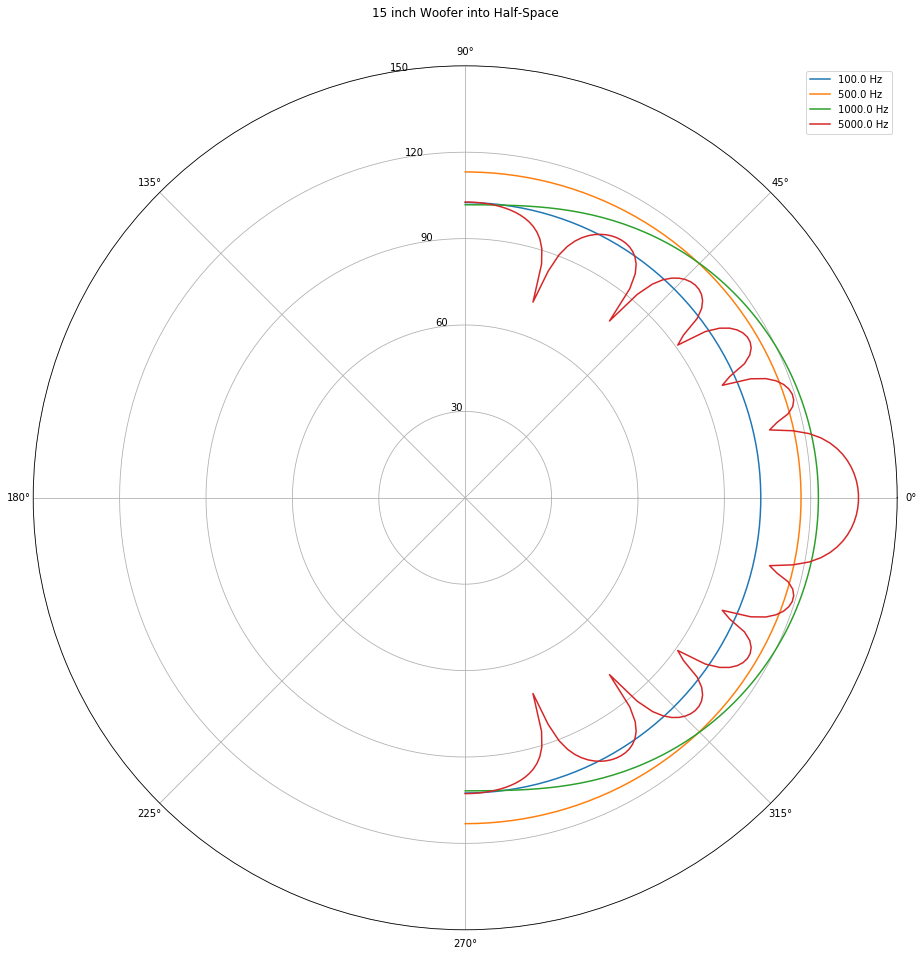

CPU times: user 684 ms, sys: 406 ms, total: 1.09 s
Wall time: 2.4 s


In [2]:
%%time
solver = RayleighSolver3D(aVertex, aTriangle)
boundaryCondition = BoundaryCondition(solver.numberOfElements())
boundaryCondition.alpha.fill(0.0)
boundaryCondition.beta.fill(1.0)
boundaryCondition.f.fill(V)

aK = frequencyToWavenumber(aFrequency)
aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aK)
polarPlot("15 inch Woofer into Half-Space", aFrequency, aAngle, aMagnitudes)

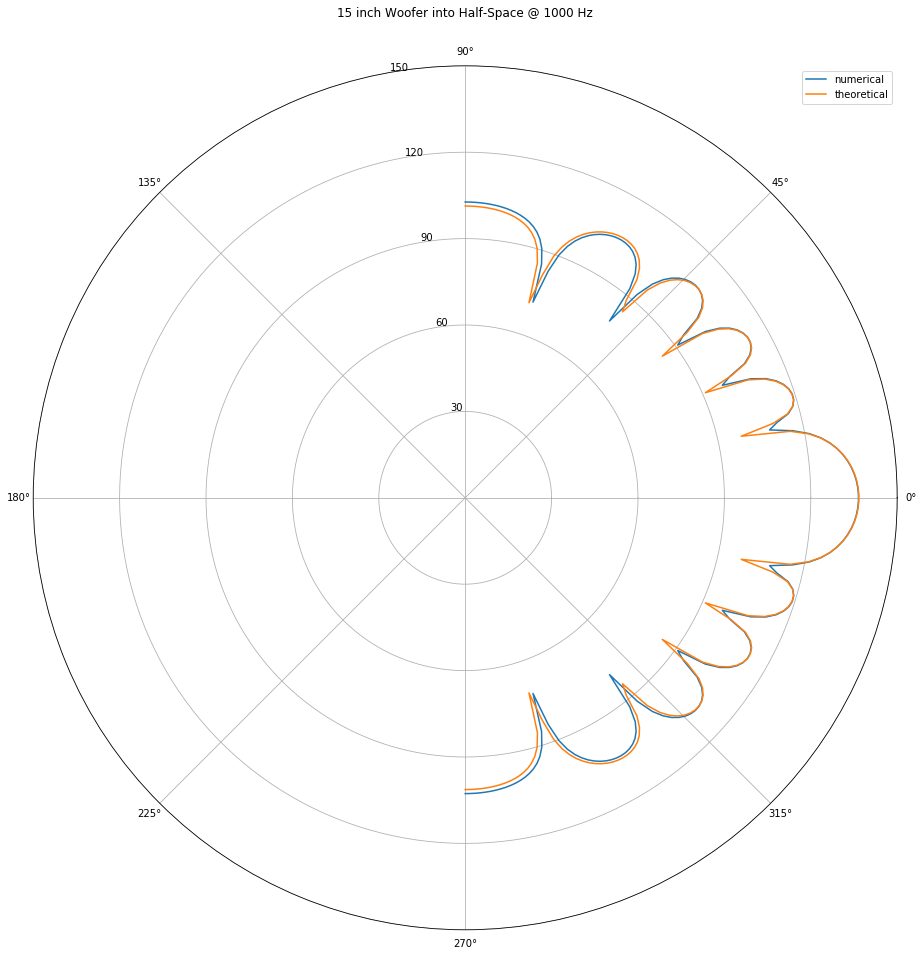

CPU times: user 602 ms, sys: 319 ms, total: 922 ms
Wall time: 492 ms


In [3]:
%%time
k = frequencyToWavenumber(5000.0)
aTheoreticalMagnitude = theoreticalMagnitude(r, V, k, 5.0, aAngle)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.set_title("15 inch Woofer into Half-Space @ 1000 Hz")
ax.plot(aAngle, aMagnitudes[3], label="numerical")
ax.plot(aAngle, aTheoreticalMagnitude, label="theoretical")
ax.legend()
ax.set_rgrids([30, 60, 90, 120, 150], horizontalalignment="left")
ax.set_rlabel_position(100.0)  # get radial labels away from plotted line
ax.grid(True)
plt.show()

CPU times: user 208 ms, sys: 7.01 ms, total: 215 ms
Wall time: 278 ms


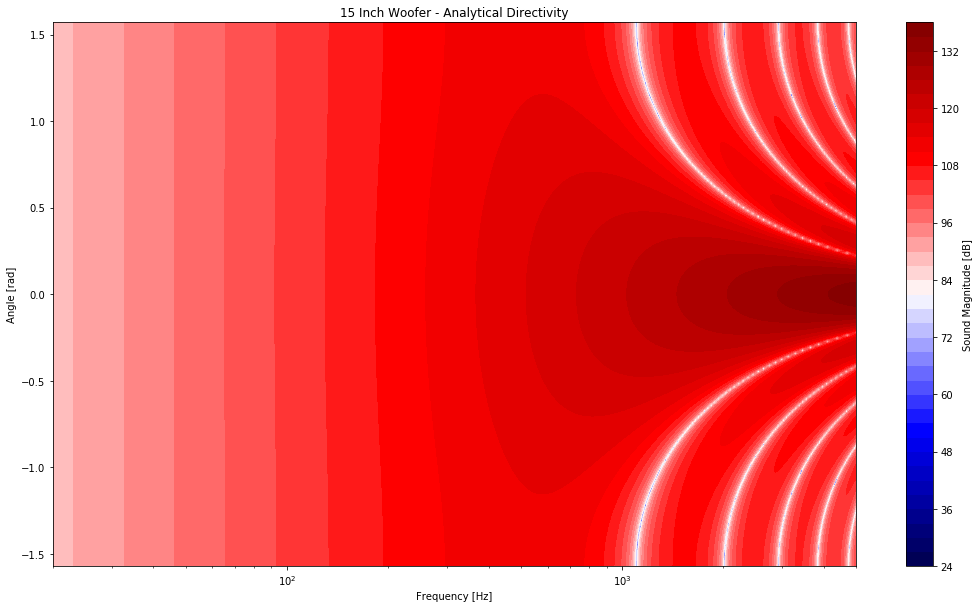

In [4]:
%%time
frequencySamples = 600
aFrequency = np.logspace(np.log10(20), np.log10(5000), frequencySamples)
angleSamples = 180
aSamples, _, aAngle = semiCircle(5, angleSamples, "yz")
aWavenumber = frequencyToWavenumber(aFrequency)

aMagnitudes = Parallel(n_jobs=4)(delayed(theoreticalMagnitude)(r, V, k, 5.0, aAngle) for k in aWavenumber)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap("15 Inch Woofer - Analytical Directivity", 
             aFrequency, aAngle, aMagnitudes, 3)

CPU times: user 653 ms, sys: 48.1 ms, total: 701 ms
Wall time: 2min 34s


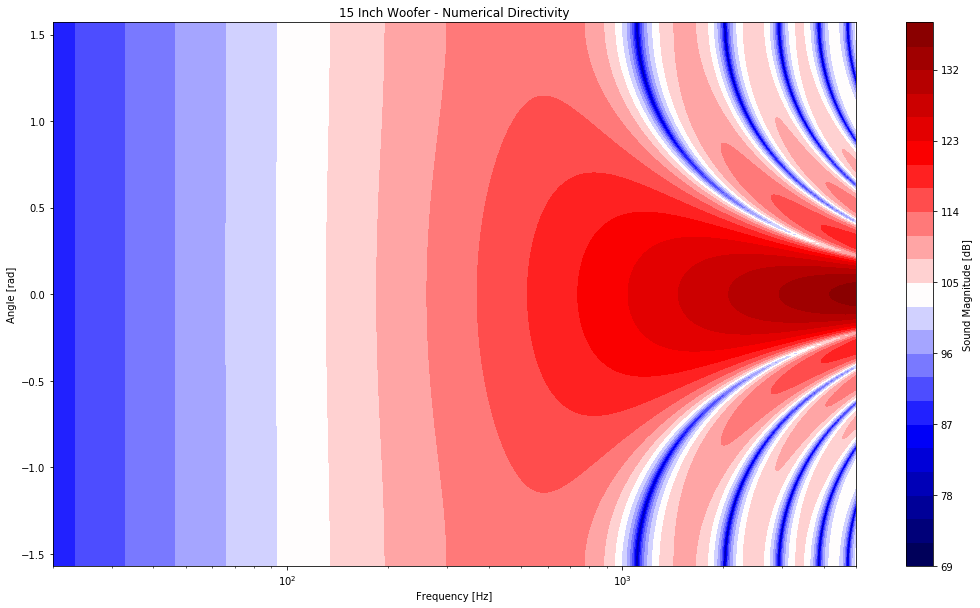

In [8]:
%%time
aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aWavenumber)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap("15 Inch Woofer - Numerical Directivity",
             aFrequency, aAngle, aMagnitudes, 3)

In [6]:
%%time
aAnalyticalZm = analyticalZm(r, aWavenumber, density, c)

aNumericalZm = Parallel(n_jobs=4)(delayed(numericalZm)(k, boundaryCondition) for k in aWavenumber)
aNumericalZm = np.asarray(aNumericalZm)

CPU times: user 455 ms, sys: 58.6 ms, total: 513 ms
Wall time: 1min 43s


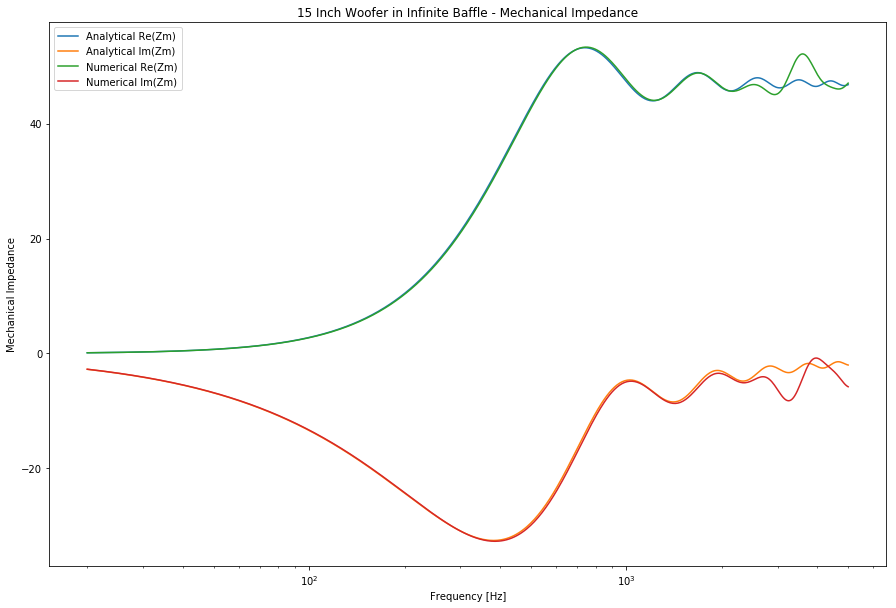

In [7]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('15 Inch Woofer in Infinite Baffle - Mechanical Impedance')
ax.set_xlabel('Frequency [Hz]')
ax.set_xscale('log') 
ax.set_ylabel('Mechanical Impedance')
ax.plot(aFrequency, np.real(aAnalyticalZm), label='Analytical Re(Zm)')
ax.plot(aFrequency, np.imag(aAnalyticalZm), label='Analytical Im(Zm)')
ax.plot(aFrequency, np.real(aNumericalZm), label='Numerical Re(Zm)')
ax.plot(aFrequency, np.imag(aNumericalZm), label='Numerical Im(Zm)')
ax.legend()